# OutlierTrimmer
The OutlierTrimmer() removes observations with outliers from the dataset.

It works only with numerical variables. A list of variables can be indicated.
Alternatively, the OutlierTrimmer() will select all numerical variables.

The OutlierTrimmer() first calculates the maximum and /or minimum values
beyond which a value will be considered an outlier, and thus removed.

Limits are determined using:

- a Gaussian approximation
- the inter-quantile range proximity rule
- percentiles.

### Example:

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.outliers import OutlierTrimmer

In [2]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv(
        'https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['embarked'].fillna('C', inplace=True)
    data['fare'] = data['fare'].astype('float')
    data['fare'].fillna(data['fare'].median(), inplace=True)
    data['age'] = data['age'].astype('float')
    data['age'].fillna(data['age'].median(), inplace=True)
    data.drop(['name', 'ticket'], axis=1, inplace=True)
    return data

# To plot histogram of given numerical feature


def plot_hist(data, col):
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=30)
    plt.title("Distribution of " + col)
    return plt.show()

In [3]:
# Loading titanic dataset
data = load_titanic()
data.sample(5)

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
675,3,0,male,21.0,0,0,7.775,n,S,NaN,NaN,"Brennes, Norway New York"
558,2,1,female,18.0,0,2,13.000,n,S,16,NaN,"Finland / Minneapolis, MN"
194,1,0,male,30.0,0,0,26.000,C,S,NaN,NaN,"Brockton, MA"
217,1,0,male,64.0,0,0,26.000,n,S,NaN,263,"Isle of Wight, England"
473,2,0,male,28.0,0,0,0.000,n,S,NaN,NaN,Belfast


In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data.drop('survived', axis=1),
                                                    data['survived'],
                                                    test_size=0.3,
                                                    random_state=0)

print("train data shape before removing outliers:", X_train.shape)
print("test data shape before removing outliers:", X_test.shape)

train data shape before removing outliers: (916, 11)
test data shape before removing outliers: (393, 11)


In [5]:
# let's find out the maximum Age and maximum Fare in the titanic

print("Max age:", data.age.max())
print("Max fare:", data.fare.max())

print("Min age:", data.age.min())
print("Min fare:", data.fare.min())

Max age: 80.0
Max fare: 512.3292
Min age: 0.1667
Min fare: 0.0


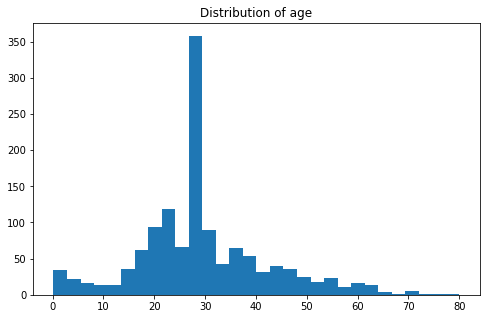

In [6]:
# Histogram of age feature before capping outliers
plot_hist(data, 'age')

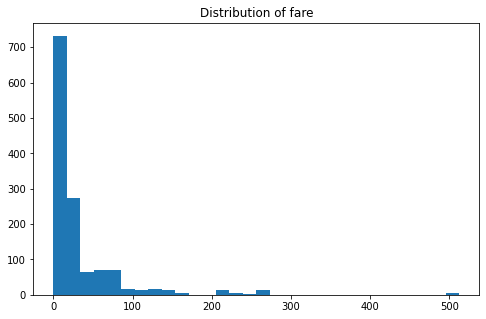

In [7]:
# Histogram of fare feature before capping outliers
plot_hist(data, 'fare')

### Outlier trimming using Gaussian limits:
The transformer will find the maximum and / or minimum values to
    trim the variables using the Gaussian approximation.


- right tail: mean + 3* std
- left tail: mean - 3* std

In [8]:
'''Parameters
----------

capping_method : str, default=gaussian
    Desired capping method. Can take 'gaussian', 'iqr' or 'quantiles'.
    
tail : str, default=right
    Whether to cap outliers on the right, left or both tails of the distribution.
    Can take 'left', 'right' or 'both'.

fold: int or float, default=3
    How far out to to place the capping values. The number that will multiply
    the std or IQR to calculate the capping values.

variables : list, default=None

missing_values: string, default='raise'
    Indicates if missing values should be ignored or raised.'''

# removing outliers based on right tail of age and fare columns using gaussian capping method
trimmer = OutlierTrimmer(
    capping_method='gaussian', tail='right', fold=3, variables=['age', 'fare'])

# fitting trimmer object to training data
trimmer.fit(X_train)

OutlierTrimmer(variables=['age', 'fare'])

In [9]:
# here we can find the maximum caps allowed
trimmer.right_tail_caps_

{'age': 67.49048447470315, 'fare': 174.78162171790441}

In [10]:
# this dictionary is empty, because we selected only right tail
trimmer.left_tail_caps_

{}

In [15]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

# let's check the new maximum Age and maximum Fare in the titanic
print("Max age:", train_t.age.max())
print("Max fare:", train_t.fare.max())

Max age: 66.0
Max fare: 164.8667


In [12]:
print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (887, 11)
29 observations are removed

test data shape after removing outliers: (376, 11)
17 observations are removed


### Gaussian approximation trimming, both tails

In [16]:
# Trimming the outliers at both tails using gaussian  method
trimmer = OutlierTrimmer(
    capping_method='gaussian', tail='both', fold=2, variables=['fare', 'age'])
trimmer.fit(X_train)

OutlierTrimmer(fold=2, tail='both', variables=['fare', 'age'])

In [17]:
print("Minimum caps :", trimmer.left_tail_caps_)

print("Maximum caps :", trimmer.right_tail_caps_)

Minimum caps : {'fare': -62.30099726608475, 'age': 4.681562024142586}
Maximum caps : {'fare': 127.36509792110658, 'age': 54.92869998459104}


In [18]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (803, 11)
113 observations are removed

test data shape after removing outliers: (334, 11)
59 observations are removed


### Inter Quartile Range, both tails
The transformer will find the boundaries using the IQR proximity rule.
**IQR limits:**

- right tail: 75th quantile + 3* IQR
- left tail:  25th quantile - 3* IQR

where IQR is the inter-quartile range: 75th quantile - 25th quantile.


In [19]:
# trimming at both tails using iqr capping method
trimmer = OutlierTrimmer(
    capping_method='iqr', tail='both', variables=['age', 'fare'])

trimmer.fit(X_train)

OutlierTrimmer(capping_method='iqr', tail='both', variables=['age', 'fare'])

In [20]:
print("Minimum caps :", trimmer.left_tail_caps_)

print("Maximum caps :", trimmer.right_tail_caps_)

Minimum caps : {'age': -13.0, 'fare': -62.24179999999999}
Maximum caps : {'age': 71.0, 'fare': 101.4126}


In [21]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (857, 11)
59 observations are removed

test data shape after removing outliers: (365, 11)
28 observations are removed


### percentiles or quantiles:
The limits are given by the percentiles.
- right tail: 98th percentile
- left tail:  2nd percentile

In [23]:
# trimming at both tails using quantiles capping method
trimmer = OutlierTrimmer(capping_method='quantiles',
                         tail='both', fold=0.02, variables=['age', 'fare'])

trimmer.fit(X_train)

OutlierTrimmer(capping_method='quantiles', fold=0.02, tail='both',
               variables=['age', 'fare'])

In [24]:
print("Minimum caps :", trimmer.left_tail_caps_)

print("Maximum caps :", trimmer.right_tail_caps_)

Minimum caps : {'age': 2.0, 'fare': 6.44125}
Maximum caps : {'age': 61.69999999999993, 'fare': 211.5}


In [25]:
# transforming the training and testing data
train_t = trimmer.transform(X_train)
test_t = trimmer.transform(X_test)

print("train data shape after removing outliers:", train_t.shape)
print(f"{X_train.shape[0] - train_t.shape[0]} observations are removed\n")

print("test data shape after removing outliers:", test_t.shape)
print(f"{X_test.shape[0] - test_t.shape[0]} observations are removed")

train data shape after removing outliers: (852, 11)
64 observations are removed

test data shape after removing outliers: (358, 11)
35 observations are removed


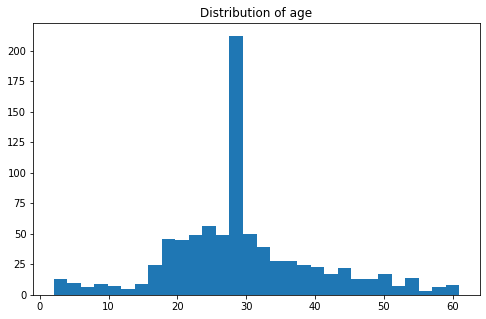

In [26]:
# Histogram of age feature after removing outliers
plot_hist(train_t, 'age')

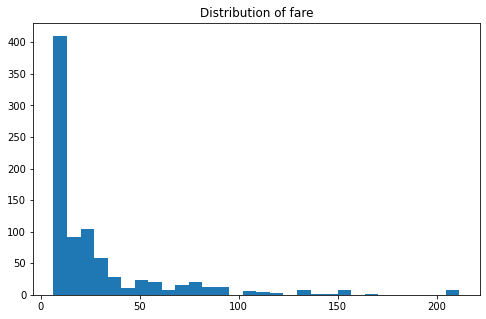

In [27]:
# Histogram of fare feature after removing outliers
plot_hist(train_t, 'fare')